__Example 7.15.__ Consider the spring model

$\ddot{z} + C\dot{z} + Kz = 0$

$z(0) = 2$, $\dot{z}(0) = -C$

with displacement observations so that

$y = \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} z \\ \dot{z} \end{bmatrix} = z$.

The solution is 

$z(t) = 2e^{-Ct/2}\cos{\left( \sqrt{K-C^2/4} t\right)}$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import *
import numpy as np

In [2]:
K = 20.5
C0 = 1.5
sigma = 0.1

In [3]:
def f(t,C,K):
    return 2*exp(-C*t/2)*cos(sqrt(K-C**2/4)*t)

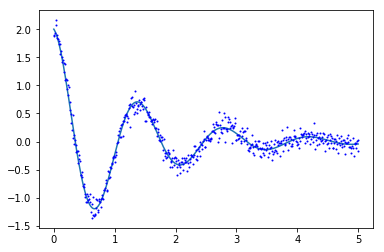

In [4]:
N = 501
t = linspace(0, 5, N)
fig, ax  = plt.subplots()
ax.plot(t, f(t,C0,K));
data = f(t,C0,K) + np.random.normal(0, sigma, N)
ax.plot(t, data,'bo',markersize=1)

In [5]:
def SSE(C):
    return sum( (2*exp(-C*t/2)*cos(sqrt(K-C**2/4)*t)-data)**2 )

In [6]:
from scipy import optimize
C_OLS=optimize.fmin(SSE,1)
C_OLS

Optimization terminated successfully.
         Current function value: 5.102952
         Iterations: 15
         Function evaluations: 30


array([1.51445313])

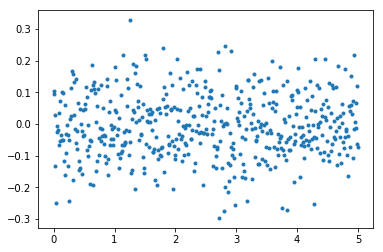

In [7]:
fig, ax  = plt.subplots()
ax.plot(t, f(t,C_OLS,K)-data,'.');

$\dfrac{\partial y}{\partial C} = e^{-C t/2} \left[ \dfrac{Ct}{\sqrt{4K-C^2}} \sin \left( t \sqrt{K - C^2/4}\right) - t \cos \left( t \sqrt{K - C^2/4}\right) \right]$

In [8]:
C = C_OLS
w = sqrt(K - C**2/4)
dydC = exp(-C*t/2)*(C*t/sqrt(4*K-C**2)*sin(w*t)+t*cos(w*t))

$V = \sigma_C^2 = \sigma_0^2 [ X(q)^T X(q) ]^{-1}$, $X(q) = \left[ \dfrac{\partial y}{\partial C} (t_1,q),\dots,\dfrac{\partial y}{\partial C} (t_N,q) \right]^T$

In [9]:
V = sigma**2/np.dot(dydC,dydC)
V

0.0003452099398497526

95% confidence interval is:

In [10]:
C_OLS + 1.96*sqrt(V)*np.array([-1,1])

array([1.46473761, 1.53662958])

Note that the _interval_ is random. How often is the true value in the interval?
If we repeat the problem (not possible in practice), we can check how often the true value is within the interval.

In [11]:
mc = 1000
Csamples = np.zeros(mc)
InInterval = np.zeros(mc)
for imc in range(0,mc):
    data = f(t,C0,K) + np.random.normal(0, sigma, N)
    Csamples[imc]=optimize.fmin(SSE,1.5,disp=0)
    C = Csamples[imc]
    w = sqrt(K - C**2/4)
    dydC = exp(-C*t/2)*(C*t/sqrt(4*K-C**2)*sin(w*t)+t*cos(w*t))
    V = sigma**2/np.dot(dydC,dydC)
    InInterval[imc] = (C0 < C+1.96*sqrt(V)) & (C0 > C-1.96*sqrt(V))

In [12]:
np.mean(InInterval)

0.954

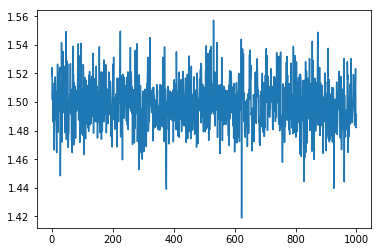

In [13]:
fig, ax  = plt.subplots()
ax.plot(Csamples);

(array([ 1.,  0.,  0.,  0.,  0.,  2.,  2.,  1.,  1.,  0.,  6., 10., 13.,
        30., 35., 47., 59., 60., 78., 71., 96., 87., 83., 81., 65., 54.,
        37., 21., 13., 17., 11., 12.,  3.,  2.,  1.,  1.]),
 array([1.4189209 , 1.42276204, 1.42660319, 1.43044434, 1.43428548,
        1.43812663, 1.44196777, 1.44580892, 1.44965007, 1.45349121,
        1.45733236, 1.4611735 , 1.46501465, 1.46885579, 1.47269694,
        1.47653809, 1.48037923, 1.48422038, 1.48806152, 1.49190267,
        1.49574382, 1.49958496, 1.50342611, 1.50726725, 1.5111084 ,
        1.51494954, 1.51879069, 1.52263184, 1.52647298, 1.53031413,
        1.53415527, 1.53799642, 1.54183757, 1.54567871, 1.54951986,
        1.553361  , 1.55720215]),
 <a list of 36 Patch objects>)

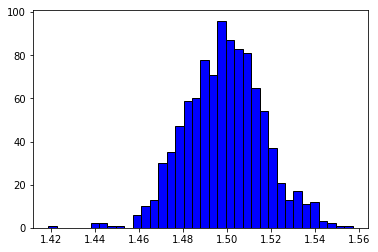

In [14]:
fig, ax  = plt.subplots()
plt.hist(Csamples, color = 'blue', edgecolor = 'black',bins = int(180/5))

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


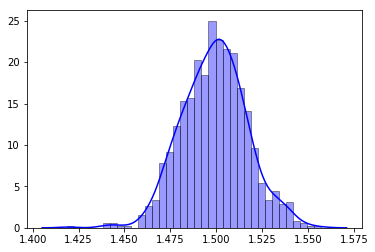

In [15]:
import seaborn as sns
sns.distplot(Csamples, hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [16]:
np.mean(Csamples)

1.4989505126953124

In [17]:
np.std(Csamples)

0.017642643552549287